In [3]:
# dependancies, parameters, and setup
# important paper do not forget:
# https://arxiv.org/pdf/1610.02415v1.pdf
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.manifold import TSNE

%matplotlib inline  

train_dir = "/home/ubuntu/Desktop/seq2seq/seq2seq_train_protein/"
data_dir = "/home/ubuntu/Desktop/seq2seq/protein_data/"

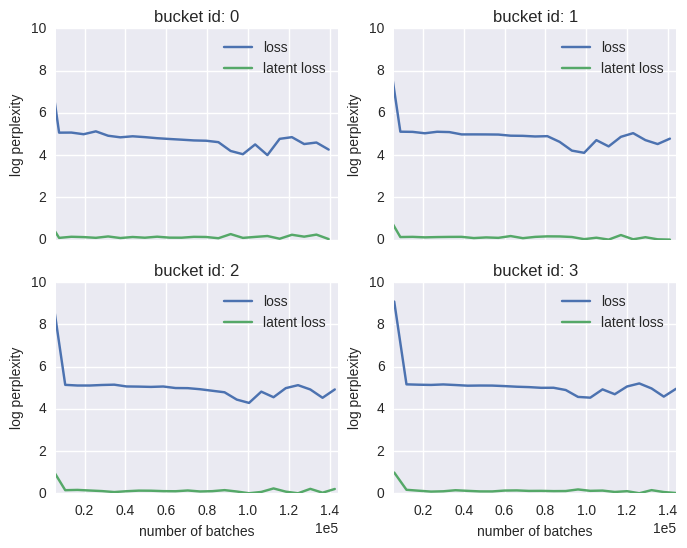

In [4]:
# error training summaries

# training error
df_train_er = pd.read_csv(train_dir + "error_train_log.txt",
                          names=["", "global step", "learning rate", "step time", "loss", "latent loss"],
                          sep=" ",
                          index_col=False
                         )
# step time
# df_train_er.plot(y=3, title="train step time")

# loss
# df_train_er.plot(y=4, title="train loss")

# latent_loss
# df_train_er.plot(y=5, title="train latent loss")

# testing error by bucket
df_test_er = pd.read_csv(train_dir + "error_test_log.txt",
                          names=["", "bucket_id", "loss", "latent loss"],
                          sep=" ",
                          index_col=False
                         )
df_test_er.index = list(range(1500,(df_test_er.shape[0]+1)*1500, 1500))

# df_test_er = df_test_er.iloc[:200,:]

f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=False)
axes = [ax1, ax2, ax3, ax4]

for bucket_id in range(4):
  ax = axes[bucket_id]
  ax = df_test_er[df_test_er.bucket_id == bucket_id][["loss", "latent loss"]].plot(
    title="bucket id: " + str(bucket_id), ax=ax, figsize=(8, 6))
  ax.set_xlabel('number of batches', fontsize=10)
  ax.set_ylabel('log perplexity', fontsize = 10)
  ax.tick_params(axis='both', which='major', labelsize=10)
  ax.ticklabel_format(axis='both', style='sci', scilimits=(-4,4))

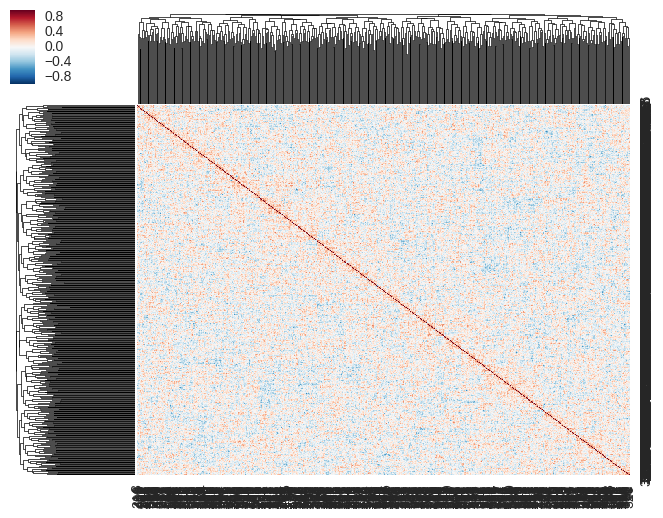

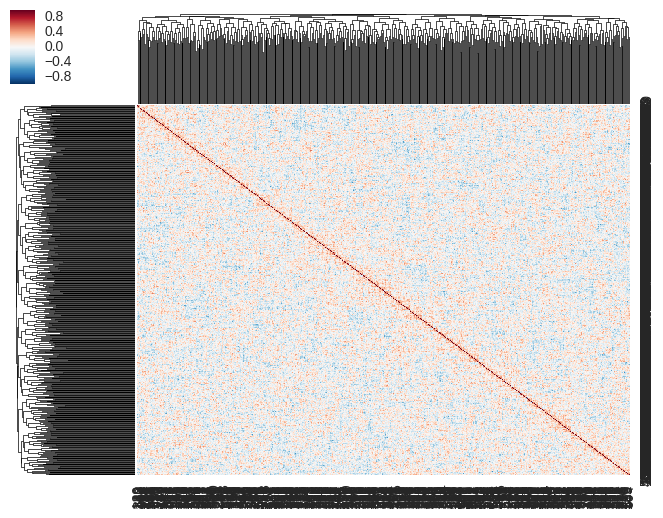

In [5]:
# visualize embeddings

# embeddings after batch 1,500
latent_df = pd.read_csv(train_dir + "embedd_df_1.csv", sep=" ")
ax = sns.clustermap(cosine_similarity(np.random.normal(size=latent_df.iloc[:,1:].values.shape)), figsize=(8, 6))

# embeddings after batch 171,000
latent_df = pd.read_csv(train_dir + "embedd_df_31501.csv", sep=" ")
ax = sns.clustermap(cosine_similarity(latent_df.iloc[:,1:].values), figsize=(8, 6))



In [ ]:
# visualize latent space distribution (by bucket)

# latent_z = pd.read_csv(train_dir + "latent_z_0_31501.txt", sep=" ", header=None)
# model = TSNE(n_components=2, random_state=0)
# np.set_printoptions(suppress=True)
# x, y = model.fit_transform(latent_z.iloc[]).T
# plt.scatter(x, y)
# latent_z

# TODO color scatter plot by hydrophobicity

# TODO color scatter plot (binary) by transmembrane vs not transmembrane (requires lookup on NCBI)

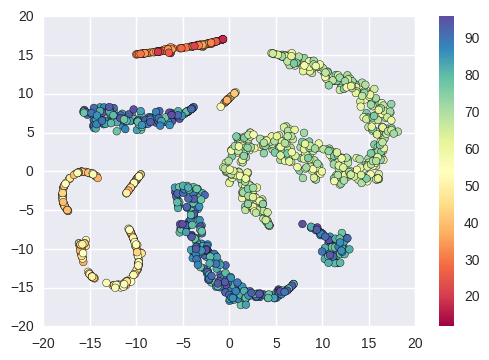

In [6]:
# make plot of represenation colored by sequence length
files = ["latent_z_0_31501.txt", "latent_z_1_31501.txt", "latent_z_2_31501.txt", "latent_z_3_31501.txt"]

def get_lens_and_reps(filename):
  lengths = []
  z_representations = []
  seqs = []

  lines = open(train_dir + filename).readlines()
  assert len(lines) % 2 == 0
  n_lines = len(lines)

  for i in range(0, n_lines, 2):
    sequence = "".join(lines[i].split()[1:])
    seqs.append(sequence)
    representation = lines[i+1]

    length = len(sequence)
    lengths.append(length)
    rep_formated = np.array([float(num) for num in representation.split()[1:]])
    z_representations.append(rep_formated)

  return lengths, z_representations, seqs

lengths = []
z_reps = []
seqs = []

for filename in files:
  bucket_lengths, bucket_z_reps, bucket_seqs = get_lens_and_reps(filename)
  lengths = lengths + bucket_lengths
  z_reps = z_reps + bucket_z_reps
  seqs = seqs + bucket_seqs

data = np.array(z_reps)
colors = np.array(lengths)

# do tSNE
model = TSNE(n_components=2, random_state=0)
x, y = model.fit_transform(data).T

# do plot

f, ax = plt.subplots()
points = ax.scatter(x, y, c=colors, s=30, cmap=plt.get_cmap("Spectral"))
f.colorbar(points)

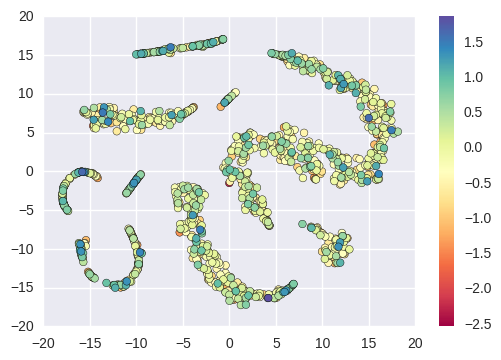

In [19]:
# now do the same, but now colored for hydrophobicity / seq_length

kd = { 'A': 1.8,'R':-4.5,'N':-3.5,'D':-3.5,'C': 2.5,
       'Q':-3.5,'E':-3.5,'G':-0.4,'H':-3.2,'I': 4.5,
       'L': 3.8,'K':-3.9,'M': 1.9,'F': 2.8,'P':-1.6,
       'S':-0.8,'T':-0.7,'W':-0.9,'Y':-1.3,'V': 4.2 }

colors = []
for seq in seqs:
  seq = seq.replace("_UNK", "")
  color = sum([kd[aa] for aa in seq if aa in kd.keys()]) / len(seq)
  colors.append(color)
  
colors = np.array(colors)

f, ax = plt.subplots()
sort_ind = np.argsort(colors)

points = ax.scatter(x[sort_ind], y[sort_ind], c=colors[sort_ind], s=30, cmap=plt.get_cmap("Spectral"))
f.colorbar(points)

In [9]:
# now do the same, but now colored binary for transmembrane or not transmembrane

headers = open("protein_data/protein_dev_headers.txt").readlines()

# make sure headers are ordered correctly ("header seq" should match "seqs" order)
header_seqs = [head.strip().split(" ")[-1] for head in headers]
header_sorted_inds = [seqs.index(h_seq) for h_seq in header_seqs]

# do sort of headers
headers = [headers[i] for i in header_sorted_inds]

colors = ["membrane" in header.lower() for header in headers]

# color "transmembrane as one color and the rest as another color
# make sure transmembrane is plotted in the foreground

f, ax = plt.subplots()
sort_ind = np.argsort(colors)

points = ax.scatter(x[sort_ind], y[sort_ind], c=colors[sort_ind], s=30, cmap=plt.get_cmap("Spectral"))
f.colorbar(points)


ValueError: 'RepID=002L_FRG3G' is not in list

In [23]:
headers[0]

'>UniRef90_Q6GZX3 Uncharacterized protein 002L n=16 Tax=Ranavirus RepID=002L_FRG3G\n'

In [15]:
# TODO for a given peptide of interest, show sampling of z's and outputs with high alpha against low alpha testing set

# TODO show unguided (fully markov) random walk for a few iterations in latent space and output sequence

In [22]:
# example translations
for bucket_id in range(4):
  print("Bucket " + str(bucket_id) + ": ")
  with open(train_dir + "batch_trans_31501_bucket_{}.txt".format(bucket_id)) as f_in:
    for l in f_in:
      tokens = l.strip().split(" ")
      last_tokens = [t for t in tokens[1:] if t not in ["_EOS", "_GO"]]
      s = "".join(last_tokens).replace("_UNK", "_")
      print(tokens[0] + " " + s)
  print("\n\n\n")

Bucket 0: 
0: XWSCTKGCPDAKQCEA
0: RRRRRRRRRRRRRRLILILILIGLGLGLGLGLGLGLGLGL
0: RRRRRRRRILILRRILLILIILGLGLGLGLGLGLGLGLIL
0: RRRRRRRRRRRRRRLILIILILILGLGLGLGLGLGLGLGL
1: EPVKKKDLKKATVP
1: ALILILRRILILILILILILILILLELELELELELELELE
1: RRILILRRILILILILILILILILILRRRRLLLLLLLLLL
1: ALILILRRILILILILILILILILILILLLLLLLLLLLLL
2: MLGTTLFFTFVAVVGNLIEDLVFTVLDPRISYDD
2: _RRRRRRRRRRRRRRRRRRRRRRRRGGGGGGRRRRSASA
2: ALRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRSASASASA
2: RRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRRSA
3: MAEYGEKYAEPLISEYALRRAFWWEG
3: ALRRGGRRGGRRLTRRRRRRLTLTGLGLGLGLGLGLGLGL
3: ALRRGGGGGGGGRRRRRRRRRRLTRRRRRRRRRRRRRRGL
3: ALLLILGGGGGGLTRRRRLTLTLTGLGLGLGLGLGLGLLR
4: MDQVSRDLAFRVRVRATQVRYEKEMKIKFRKQ
4: ALILGGILGGGGILILILILILILILILILILILILILIL
4: ALILGGILILILILILILILILILILRASAALRARARARA
4: ALILGGILILILILILLLILILILILRASAALRARARARA




Bucket 1: 
0: MKRTFQPSVVHRKRTHGFRARMATKSGRLVLKRRRAKGRQRLCP
0: ARGGRRRRGGGGGGGGILILILILILILILILILILILILILILILGLGLGLGLGLGLGL
0: ARGGGGGGGGGGGGGGGGGGGGGGILILILILILILILILILILILGLGLGLGLGLGL